# Generate plots for README

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import causalpy as cp

In [2]:
seed = 42

## ANCOVA

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


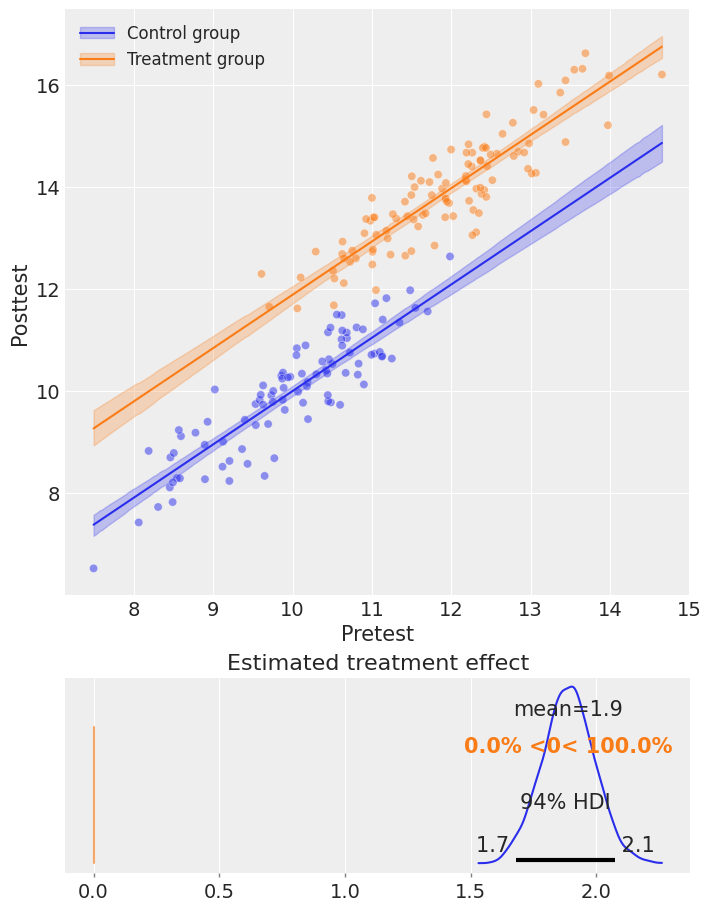

In [3]:
df = cp.load_data("anova1")
result = cp.pymc_experiments.PrePostNEGD(
    df,
    formula="post ~ 1 + C(group) + pre",
    group_variable_name="group",
    pretreatment_variable_name="pre",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)
result.plot()
plt.savefig("../../img/anova_pymc.svg", bbox_inches="tight", pad_inches=0.1)

## Difference in differences

In [4]:
df = cp.load_data("did")

In [5]:
result = cp.pymc_experiments.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group + t + group:post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    treated=1,
    untreated=0,
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
/Users/benjamv/git/CausalPy/causalpy/pymc_experiments.py:366: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_x.iloc[:, i] = 0
Sampling: [y_hat]


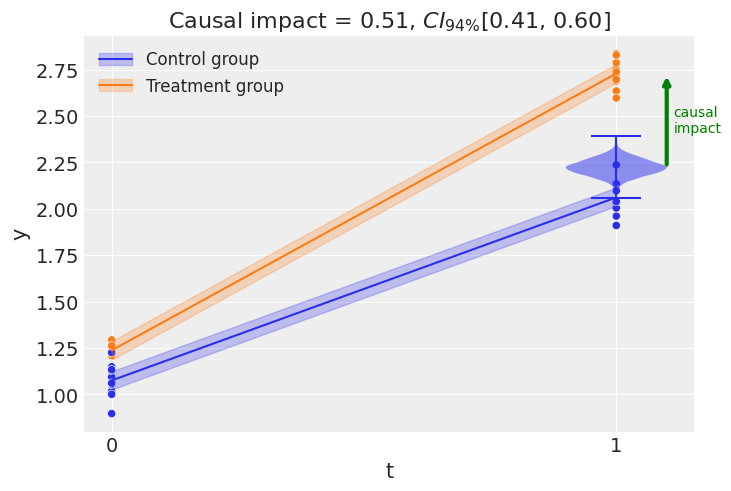

In [6]:
fig, ax = result.plot()
plt.savefig(
    "../../img/difference_in_differences_pymc.svg", bbox_inches="tight", pad_inches=0.1
)

## Regression discontinuity

In [7]:
df = cp.load_data("rd")

In [8]:
result = cp.pymc_experiments.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


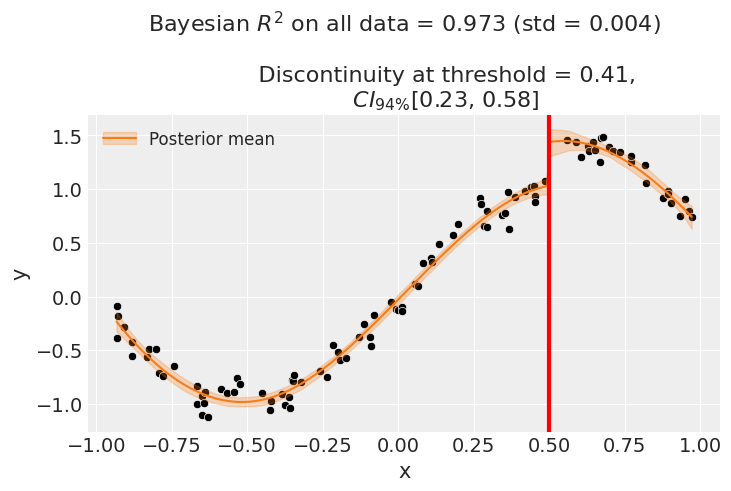

In [9]:
fig, ax = result.plot()
plt.savefig(
    "../../img/regression_discontinuity_pymc.svg", bbox_inches="tight", pad_inches=0.1
)

## Synthetic control

In [10]:
df = cp.load_data("sc")
treatment_time = 70

In [11]:
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


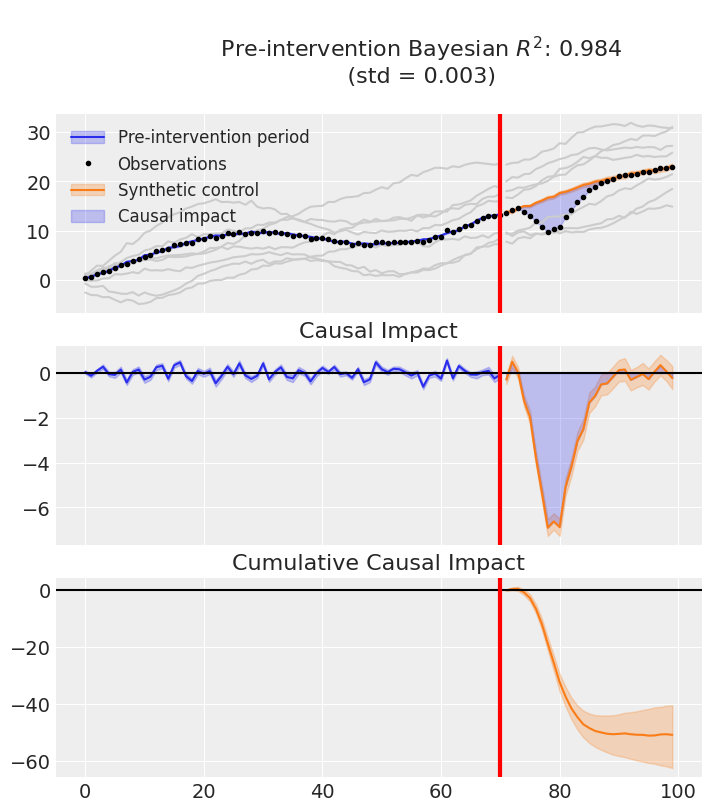

In [12]:
fig, ax = result.plot(plot_predictors=True)
plt.savefig("../../img/synthetic_control_pymc.svg", bbox_inches="tight", pad_inches=0.1)